# Training a model with little data, and using it on an iPhone app

CoreML converter requires Keras 1.2.2 and TensorFlow 1.0.0. 

## Import libraries

In [1]:
%matplotlib inline
import coremltools


In [2]:
#import vgg16; reload(vgg16)
#from vgg16 import Vgg16

## Import trained model

In [9]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [4]:
def ConvBlock(layers, model, filters, first_layer=False):
    for i in range(layers): 
        if first_layer and i == 0:
            model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
            print "adding input shape"
        else:
            model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [5]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [6]:
def VGG_16():
    model = Sequential()
    #model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64, True)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [7]:
model = VGG_16()
fpath = get_file('vgg16.h5', 'http://files.fast.ai/models/vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

adding input shape


// ft_model.model.load_weights('/srv/mus_vgg_ft_1.h5')

## Convert to CoreML 

- 1 - pop the first lambda layer
- 2 - convert to coreml
- 3 - add back the first layer [use coreml bias](http://machinethink.net/blog/help-core-ml-gives-wrong-output/)

Remove the lambda layer

In [1]:
# ft_model.model.layers.pop(0)

In [2]:
# coreml_model = coremltools.converters.keras.convert(vgg.model, input_names = 'image', class_labels = ['one','ten'])

coreml_model = coremltools.converters.keras.convert(vgg.model, input_names = 'image', class_labels = ['one','ten'])

In [ ]:
coreml_model = coremltools.converters.keras.convert(model, input_names = 'image', class_labels = ['one','ten'], is_bgr=True, red_bias=-123.68, green_bias=-116.78, blue_bias=-103.94)

0 : zeropadding2d_input_1, <keras.engine.topology.InputLayer object at 0x7f49fa616e50>
1 : zeropadding2d_1, <keras.layers.convolutional.ZeroPadding2D object at 0x7f49fa616fd0>
2 : convolution2d_1, <keras.layers.convolutional.Convolution2D object at 0x7f49fa616510>
3 : convolution2d_1__activation__, <keras.layers.core.Activation object at 0x7f49fa0075d0>
4 : zeropadding2d_2, <keras.layers.convolutional.ZeroPadding2D object at 0x7f49fa616990>
5 : convolution2d_2, <keras.layers.convolutional.Convolution2D object at 0x7f49fa5b8950>
6 : convolution2d_2__activation__, <keras.layers.core.Activation object at 0x7f49faad4a90>
7 : maxpooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x7f49fa616e90>
8 : zeropadding2d_3, <keras.layers.convolutional.ZeroPadding2D object at 0x7f49fa564d10>
9 : convolution2d_3, <keras.layers.convolutional.Convolution2D object at 0x7f49fa58b990>
10 : convolution2d_3__activation__, <keras.layers.core.Activation object at 0x7f49fa007610>
11 : zeropadding2d_4, <k

In [ ]:
coreml_model.save("vgg.mlmodel")

# Validating the model conversion

getting a random set of images and comparing the output

In [17]:
from keras.models import load_model
path = "/srv/"
batch_size = 4

In [18]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [19]:
batches = get_batches('training', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

Found 633 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


### Ground truth

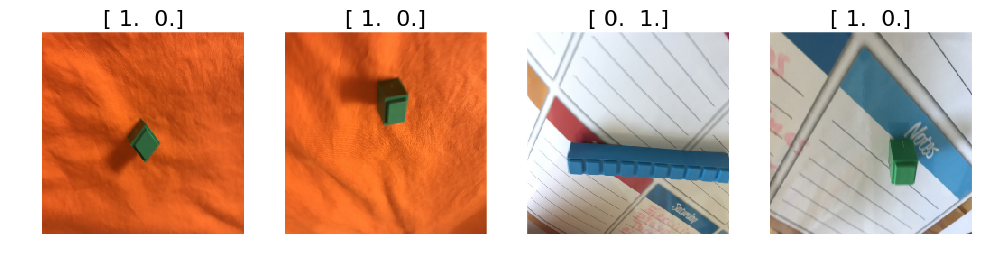

In [20]:
plots(imgs, titles=labels)

In [21]:
def pred_batch(model_in, imgs):
    preds = model_in.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [24]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
ref_model = load_model(path +'mus_vgg_ft_1.h5')

NameError: global name 'vgg_mean' is not defined

In [ ]:
pred_batch(ref_model, imgs)